<a href="https://colab.research.google.com/github/williampeoch/brain_tumor_classification/blob/main/brain_tumor_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Dataset 
# https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset

# https://www.kaggle.com/code/subhrajitchatterjee3/pytorch-brain-tumor

# https://www.kaggle.com/code/mennahtullasameh/brain-tumor-classification-pytorch

In [111]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import os

# Import Path
from pathlib import Path

# Import random
import random

# PIL
from PIL import Image

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [27]:
print(os.getcwd()) 

g:\내 드라이브\강의자료\Projects\Tumor_Classification


In [112]:
# brain_dataset_path = Path("drive") / "MyDrive" / "brain_dataset"
# brain_dataset_path = Path(".") / "brain_dataset"
# brain_dataset_path = os.path.join("./brain_dataset")
brain_dataset_path = Path(r"g:\내 드라이브\강의자료\Projects\Tumor_Classification\brain_dataset")
# brain_dataset_path = Path(".")
brain_dataset_path

WindowsPath('g:/내 드라이브/강의자료/Projects/Tumor_Classification/brain_dataset')

In [48]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\user\.cache\kagglehub\datasets\masoudnickparvar\brain-tumor-mri-dataset\versions\1


In [113]:
# Setup train and testing paths
# train_dir = brain_dataset_path / "Training"
# test_dir = brain_dataset_path / "Testing"
# train_dir = os.path.join("brain_dataset_path", "Training")
# test_dir = os.path.join("brain_dataset_path", "Testing")
train_dir = brain_dataset_path / "Training"
test_dir = brain_dataset_path / "Testing"

train_dir, test_dir

(WindowsPath('g:/내 드라이브/강의자료/Projects/Tumor_Classification/brain_dataset/Training'),
 WindowsPath('g:/내 드라이브/강의자료/Projects/Tumor_Classification/brain_dataset/Testing'))

In [114]:
data_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_dataset = ImageFolder(train_dir,
                            transform=data_transforms)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = ImageFolder(test_dir,
                           transform=data_transforms)
test_dataloader = DataLoader(test_dataset,
                             batch_size=16,
                             shuffle=False)

class_names = train_dataset.classes

## Visualize dataset

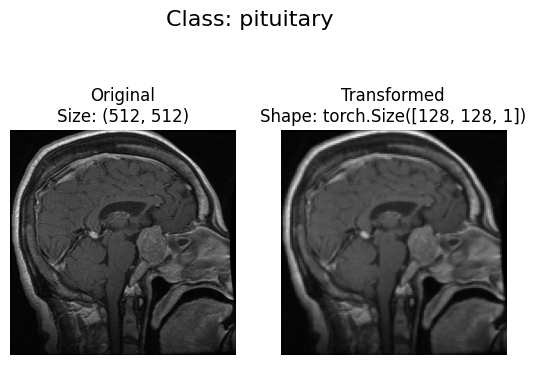

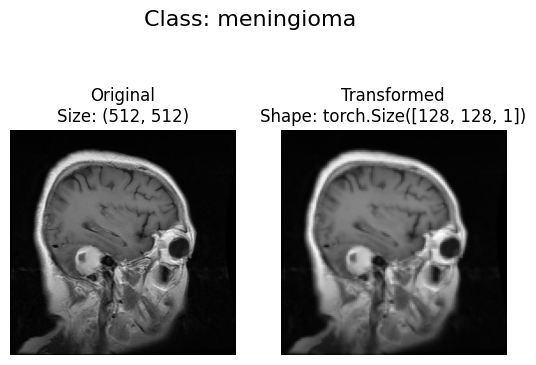

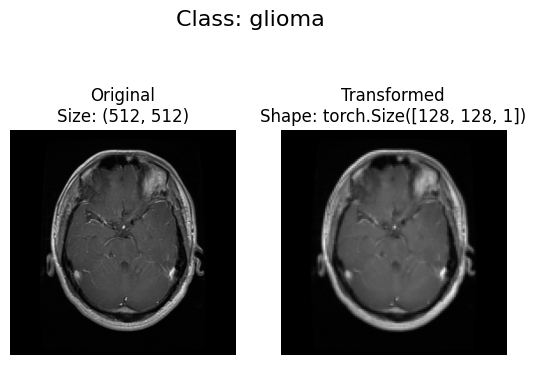

In [115]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
    """
    Selects random images from a path of images and loads/transforms them then
    plots the original vs the transformed version.
    """

    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f, cmap="gray")
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)

            # Transforms and plot target image
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image, cmap="gray")
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=list(brain_dataset_path.glob("*/*/*.jpg")),
                        transform=data_transforms,
                        n=3)

## Model

In [109]:
class BrainTumorModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=32*32*hidden_units,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x


model = BrainTumorModel(3, 10, len(train_dataset.classes)).to(device)

## Training and testing

In [116]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [117]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [118]:
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

# StepLR 스케줄러: 매 5 에폭마다 lr을 gamma 배율만큼 줄임
# scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

In [119]:
train_losses = [0]
train_accuracies = [0]
test_losses = [0]
test_accuracies = [0]

In [120]:
from tqdm.auto import tqdm

# train and test
epochs = 20
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    train_loss, train_acc = 0, 0
    model.train()

    # Add a loop to loop through the training batches
    for batch, (X, y) in enumerate(train_dataloader):

        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss and accuracy (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Divide total train loss and acc by lenght of train dataloader
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")

    train_losses.append(float(train_loss))
    train_accuracies.append(float(train_acc))

    test_loss, test_acc = 0, 0
    model.eval()

    with torch.inference_mode():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)

            test_pred = model(X)

            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

        # Calculate the test loss average per batch
        test_loss /= len(test_dataloader)

        # Calculate the test accuracy average per batch
        test_acc /= len(test_dataloader)
    
    # Learning Rate Scheduler Step  
    scheduler.step(test_loss)

    print(f"Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%\n")

    test_losses.append(float(test_loss))
    test_accuracies.append(float(test_acc))

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 0.72579 | Train acc: 70.01%


  5%|▌         | 1/20 [01:44<33:02, 104.35s/it]

Test loss: 0.8770, Test acc: 72.18%

Epoch: 1
-------
Train loss: 0.45454 | Train acc: 83.44%


 10%|█         | 2/20 [03:26<30:59, 103.29s/it]

Test loss: 0.5938, Test acc: 76.65%

Epoch: 2
-------
Train loss: 0.32371 | Train acc: 88.62%


 15%|█▌        | 3/20 [05:14<29:49, 105.26s/it]

Test loss: 0.5925, Test acc: 82.16%

Epoch: 3
-------
Train loss: 0.25423 | Train acc: 90.93%


 20%|██        | 4/20 [06:57<27:48, 104.28s/it]

Test loss: 0.2916, Test acc: 89.33%

Epoch: 4
-------
Train loss: 0.20596 | Train acc: 92.89%


 25%|██▌       | 5/20 [08:39<25:53, 103.58s/it]

Test loss: 0.3438, Test acc: 88.11%

Epoch: 5
-------
Train loss: 0.15404 | Train acc: 94.66%


 30%|███       | 6/20 [10:26<24:27, 104.80s/it]

Test loss: 0.2456, Test acc: 90.62%

Epoch: 6
-------
Train loss: 0.11364 | Train acc: 96.03%


 35%|███▌      | 7/20 [12:09<22:32, 104.04s/it]

Test loss: 0.2477, Test acc: 91.69%

Epoch: 7
-------
Train loss: 0.08709 | Train acc: 96.95%


 40%|████      | 8/20 [13:52<20:44, 103.75s/it]

Test loss: 0.2382, Test acc: 92.99%

Epoch: 8
-------
Train loss: 0.07103 | Train acc: 97.71%


 45%|████▌     | 9/20 [15:39<19:13, 104.83s/it]

Test loss: 0.1748, Test acc: 95.58%

Epoch: 9
-------
Train loss: 0.04606 | Train acc: 98.37%


 50%|█████     | 10/20 [17:22<17:21, 104.18s/it]

Test loss: 0.2031, Test acc: 94.97%

Epoch: 10
-------
Train loss: 0.05105 | Train acc: 98.35%


 55%|█████▌    | 11/20 [19:04<15:33, 103.69s/it]

Test loss: 0.3366, Test acc: 91.92%

Epoch: 11
-------
Train loss: 0.03830 | Train acc: 98.65%


 60%|██████    | 12/20 [20:52<13:58, 104.84s/it]

Test loss: 0.1871, Test acc: 94.44%

Epoch: 12
-------
Train loss: 0.01484 | Train acc: 99.58%


 65%|██████▌   | 13/20 [22:35<12:10, 104.32s/it]

Test loss: 0.1856, Test acc: 95.88%

Epoch: 13
-------
Train loss: 0.00549 | Train acc: 99.89%


 70%|███████   | 14/20 [24:19<10:24, 104.14s/it]

Test loss: 0.1828, Test acc: 95.88%

Epoch: 14
-------
Train loss: 0.00278 | Train acc: 99.98%


 75%|███████▌  | 15/20 [26:08<08:48, 105.76s/it]

Test loss: 0.2176, Test acc: 96.04%

Epoch: 15
-------
Train loss: 0.00134 | Train acc: 100.00%


 80%|████████  | 16/20 [27:52<07:00, 105.21s/it]

Test loss: 0.2118, Test acc: 95.81%

Epoch: 16
-------
Train loss: 0.00106 | Train acc: 100.00%


 85%|████████▌ | 17/20 [29:39<05:16, 105.62s/it]

Test loss: 0.2184, Test acc: 96.19%

Epoch: 17
-------
Train loss: 0.00082 | Train acc: 100.00%


 90%|█████████ | 18/20 [31:29<03:33, 106.97s/it]

Test loss: 0.2286, Test acc: 96.04%

Epoch: 18
-------
Train loss: 0.00069 | Train acc: 100.00%


 95%|█████████▌| 19/20 [33:13<01:46, 106.24s/it]

Test loss: 0.2284, Test acc: 96.04%

Epoch: 19
-------
Train loss: 0.00063 | Train acc: 100.00%


100%|██████████| 20/20 [34:59<00:00, 104.95s/it]

Test loss: 0.2302, Test acc: 96.11%



## Visualize model results

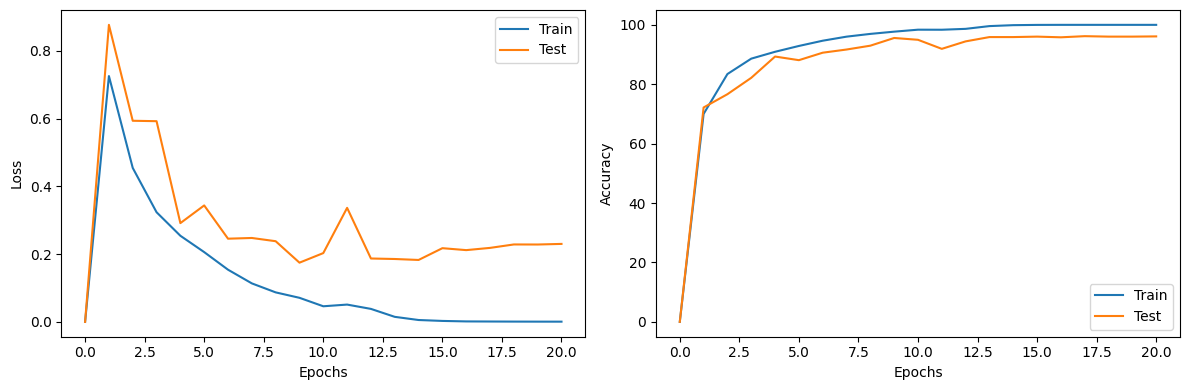

In [121]:
plt.figure(figsize=(12, 4))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(range(epochs+1), train_losses, label='Train')
plt.plot(range(epochs+1), test_losses, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(range(epochs+1), train_accuracies, label='Train')
plt.plot(range(epochs+1), test_accuracies, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [58]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare the sample (add a batch dimension and pass to target device)
            sample = torch.unsqueeze(sample, dim=0).to(device)

            # Forward pass (model outputs raw logits)
            pred_logit = model(sample)

            # Get predicition probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Get pred_prob off the GPU for further calculations
            pred_probs.append(pred_prob.cpu())

        # Stack the pred_probs to turn list into a tensor
        return torch.stack(pred_probs)

In [59]:
import random

test_samples = []
test_labels = []
for sample, label in random.sample(list(test_dataset), k=12):
    test_samples.append(sample)
    test_labels.append(label)

In [60]:
# Make predictions
pred_probs = make_predictions(model=model,
                               data=test_samples)

# Convert prediction probabilities to labels
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([1, 2, 2, 1, 0, 2, 3, 2, 1, 1, 2, 1])

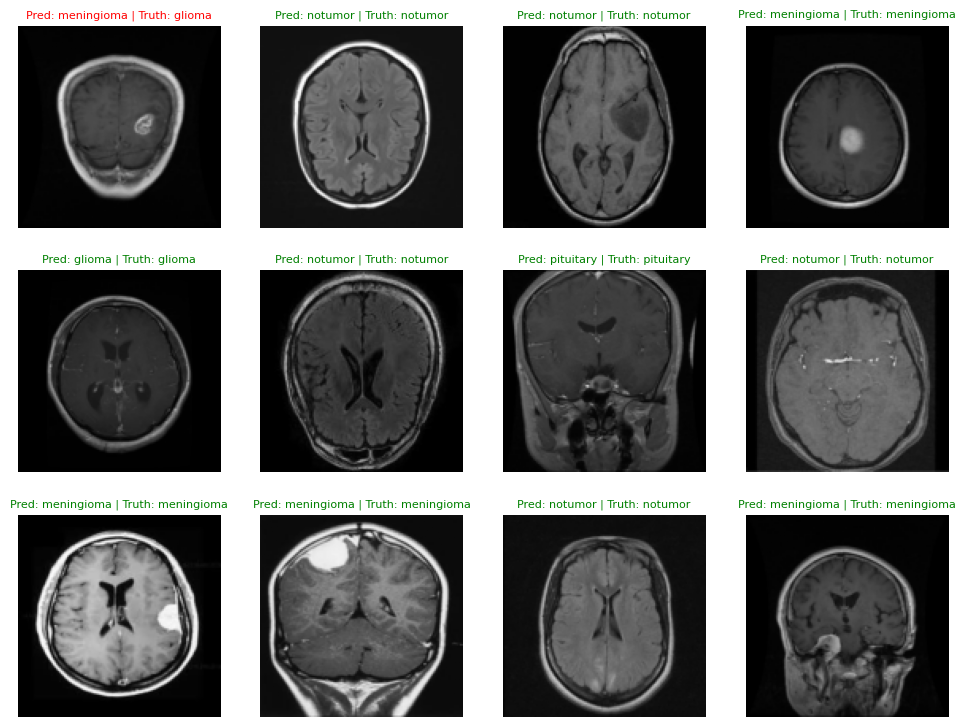

In [61]:
# Plot predictions
plt.figure(figsize=(12,9))
nrows = 3
ncols = 4
for i, sample in enumerate(test_samples):
    # Create subplot
    plt.subplot(nrows, ncols, i+1)

    # Plot the target image
    plt.imshow(sample.permute(1, 2, 0))

    # Find the prediction (in text form e.g "Sandal")
    pred_label = class_names[pred_classes[i]]

    # Get the truth label (in text form)
    truth_label = class_names[test_labels[i]]

    # Create a title for the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    # Check for equality between pred and truth and change color of title text
    if pred_label == truth_label:
        plt.title(title_text, fontsize=8, c="g")
    else:
        plt.title(title_text, fontsize=8, c="r")

    plt.axis(False)